# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
from scipy import integrate
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import math
from functools import partial
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import einsum, nn

import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from analytic_flow_funcs import compute_predictions
from image_display_funcs import plot_labelled_images, plot_image, visualize_image_trajectory, image_trajectory_animation, find_closest_matches, display_comparisons

# Set device (automatically detects GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# U-Net Code

In [2]:
# @title Click to expand (Conditional) U-Net code

# source: https://gist.github.com/TadaoYamaoka/c5ebb095cfda3d00a504302107f4637f

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, dim_out, 3, padding=1),
    )


def Downsample(dim, dim_out):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, dim_out, 1),
    )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2),
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        time_emb = self.mlp(time_emb)
        time_emb = rearrange(time_emb, "b c -> b c 1 1")
        scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        resnet_block_groups=4,
        condition=False,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.condition = condition
        input_channels = channels

        init_dim = dim
        self.init_conv = nn.Conv2d(
            input_channels, init_dim, 1, padding=0
        )  # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        if self.condition:
            self.cond_mlp = nn.Sequential(
                nn.Embedding(10, time_dim),
                nn.Linear(time_dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        (
                            Downsample(dim_in, dim_out)
                            if not is_last
                            else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                        ),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        (
                            Upsample(dim_out, dim_in)
                            if not is_last
                            else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                        ),
                    ]
                )
            )

        self.out_dim = channels

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, cond=None):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        if self.condition:
            t += self.cond_mlp(cond)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

# Loading Saved Model

In [3]:
# Model architecture
model = Unet(
    dim=32,
    channels=1,
    dim_mults=(1, 2, 4),
)
model.to(device)

# Load weights (choose one method below)
model.load_state_dict(torch.load('unet_model.pth', map_location=device))

model.eval()  # Crucial for inference!

# Verify loading worked
print("Weights loaded successfully!")

Weights loaded successfully!


# Forward Euler For Model

In [4]:
def model_forward_euler_integration(
    model: torch.nn.Module,
    initial_points: torch.Tensor,  # [batch_size, *data_shape]
    t_start: float = 0.0,
    t_end: float = 1.0,
    num_steps: int = 100,
    eps: float = 1e-3,
    time_scale: float = 999.0,  # To match your *999 scaling
    device: str = 'cpu'
) -> torch.Tensor:
    """
    Forward Euler integration using a neural network model
    
    Args:
        model: The neural network that predicts the velocity field
        initial_points: Starting noise samples [batch_size, *data_shape]
        t_start: Initial time (typically 0)
        t_end: Final time (typically 1)
        num_steps: Number of integration steps
        eps: Small offset to avoid numerical issues
        time_scale: Scaling factor for model's time input
        device: Device to perform computation on
        
    Returns:
        Tensor of shape [num_steps+1, batch_size, *data_shape] containing the trajectory
    """
    model.eval()
    dt = (t_end - t_start) / num_steps
    batch_size = initial_points.shape[0]
    
    # Initialize trajectory tensor
    trajectory = torch.zeros(num_steps + 1, *initial_points.shape, device=device)
    trajectory[0] = initial_points.clone().to(device)
    
    current_points = initial_points.clone().to(device)
    current_time = t_start
    
    with torch.no_grad():
        for step in range(1, num_steps + 1):
            # Map time to model's expected range
            t = (current_time / (t_end - eps)) * (1 - eps) + eps
            t_tensor = torch.full((batch_size,), t * time_scale, device=device)
            
            # Model prediction (velocity field)
            pred = model(current_points, t_tensor)
            
            # Forward Euler update
            current_points = current_points + pred * dt
            current_time = current_time + dt
            
            # Store current state
            trajectory[step] = current_points.clone()
    
    return trajectory.cpu()

# Using Our Model

In [5]:
import time

# Generate initial noise samples
num_noise_samples = 5
noise_samples = torch.randn(size=(num_noise_samples, 1, 28, 28),  # Match MNIST shape [B, C, H, W]
                    device=device)

start_time = time.time()
num_steps = 50

# Generate trajectory with Euler method
trajectory = model_forward_euler_integration(
    model=model,
    initial_points=noise_samples,
    t_start=0.0,
    t_end=1.0,
    num_steps=num_steps,
    device='cuda'
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")

Integration completed in 1.3043 seconds


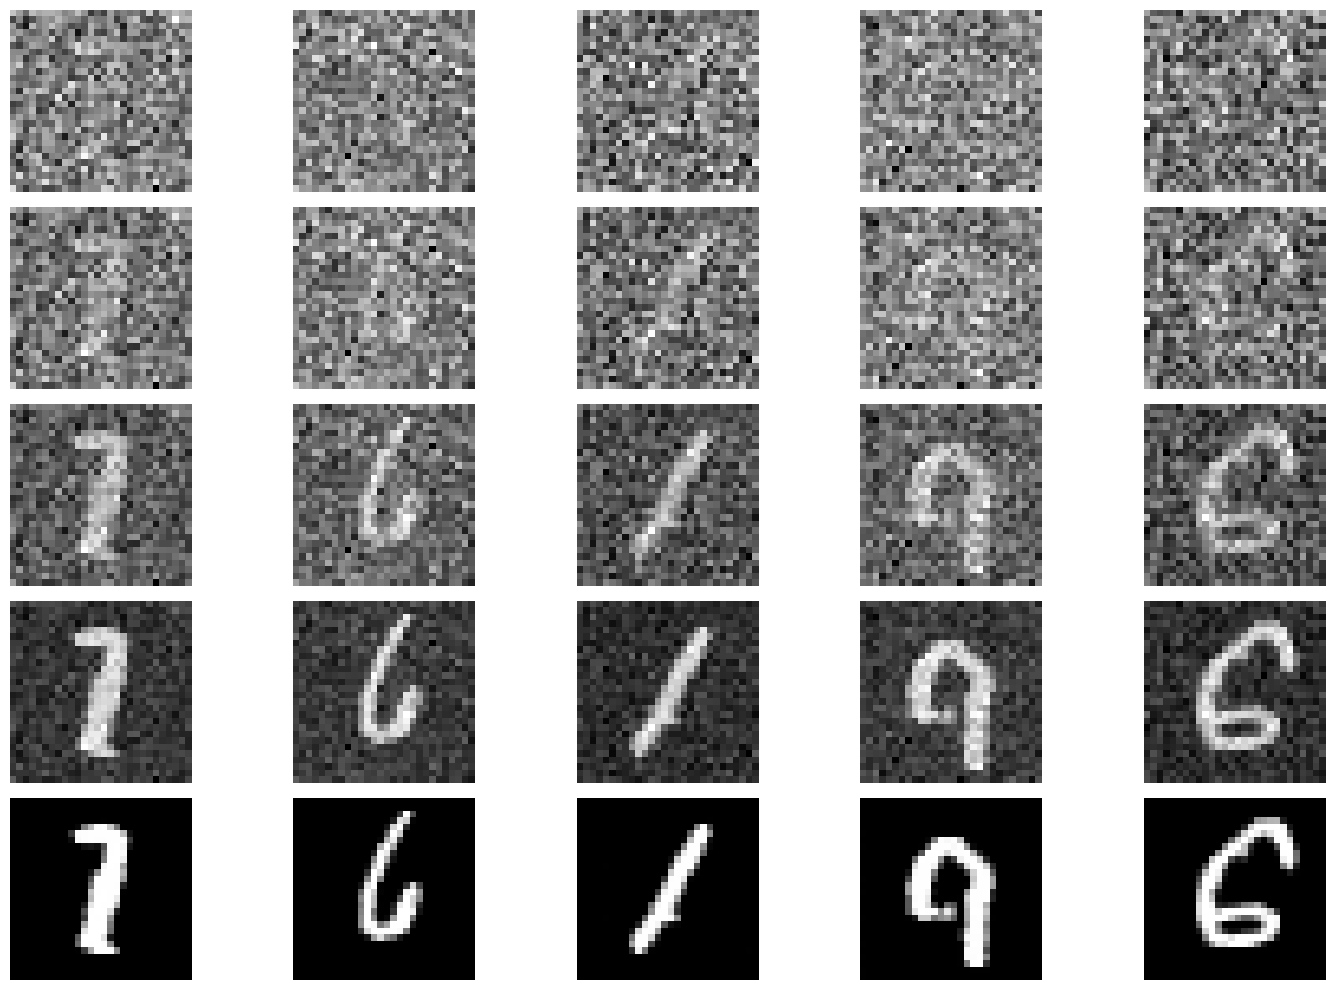

In [6]:
visualize_image_trajectory(trajectory, num_time_points=5)  # Show 5 time points

In [7]:
ani = image_trajectory_animation(trajectory)
ani.save('results/mnist_model_denoising.gif', writer='pillow', fps=20, dpi=80)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

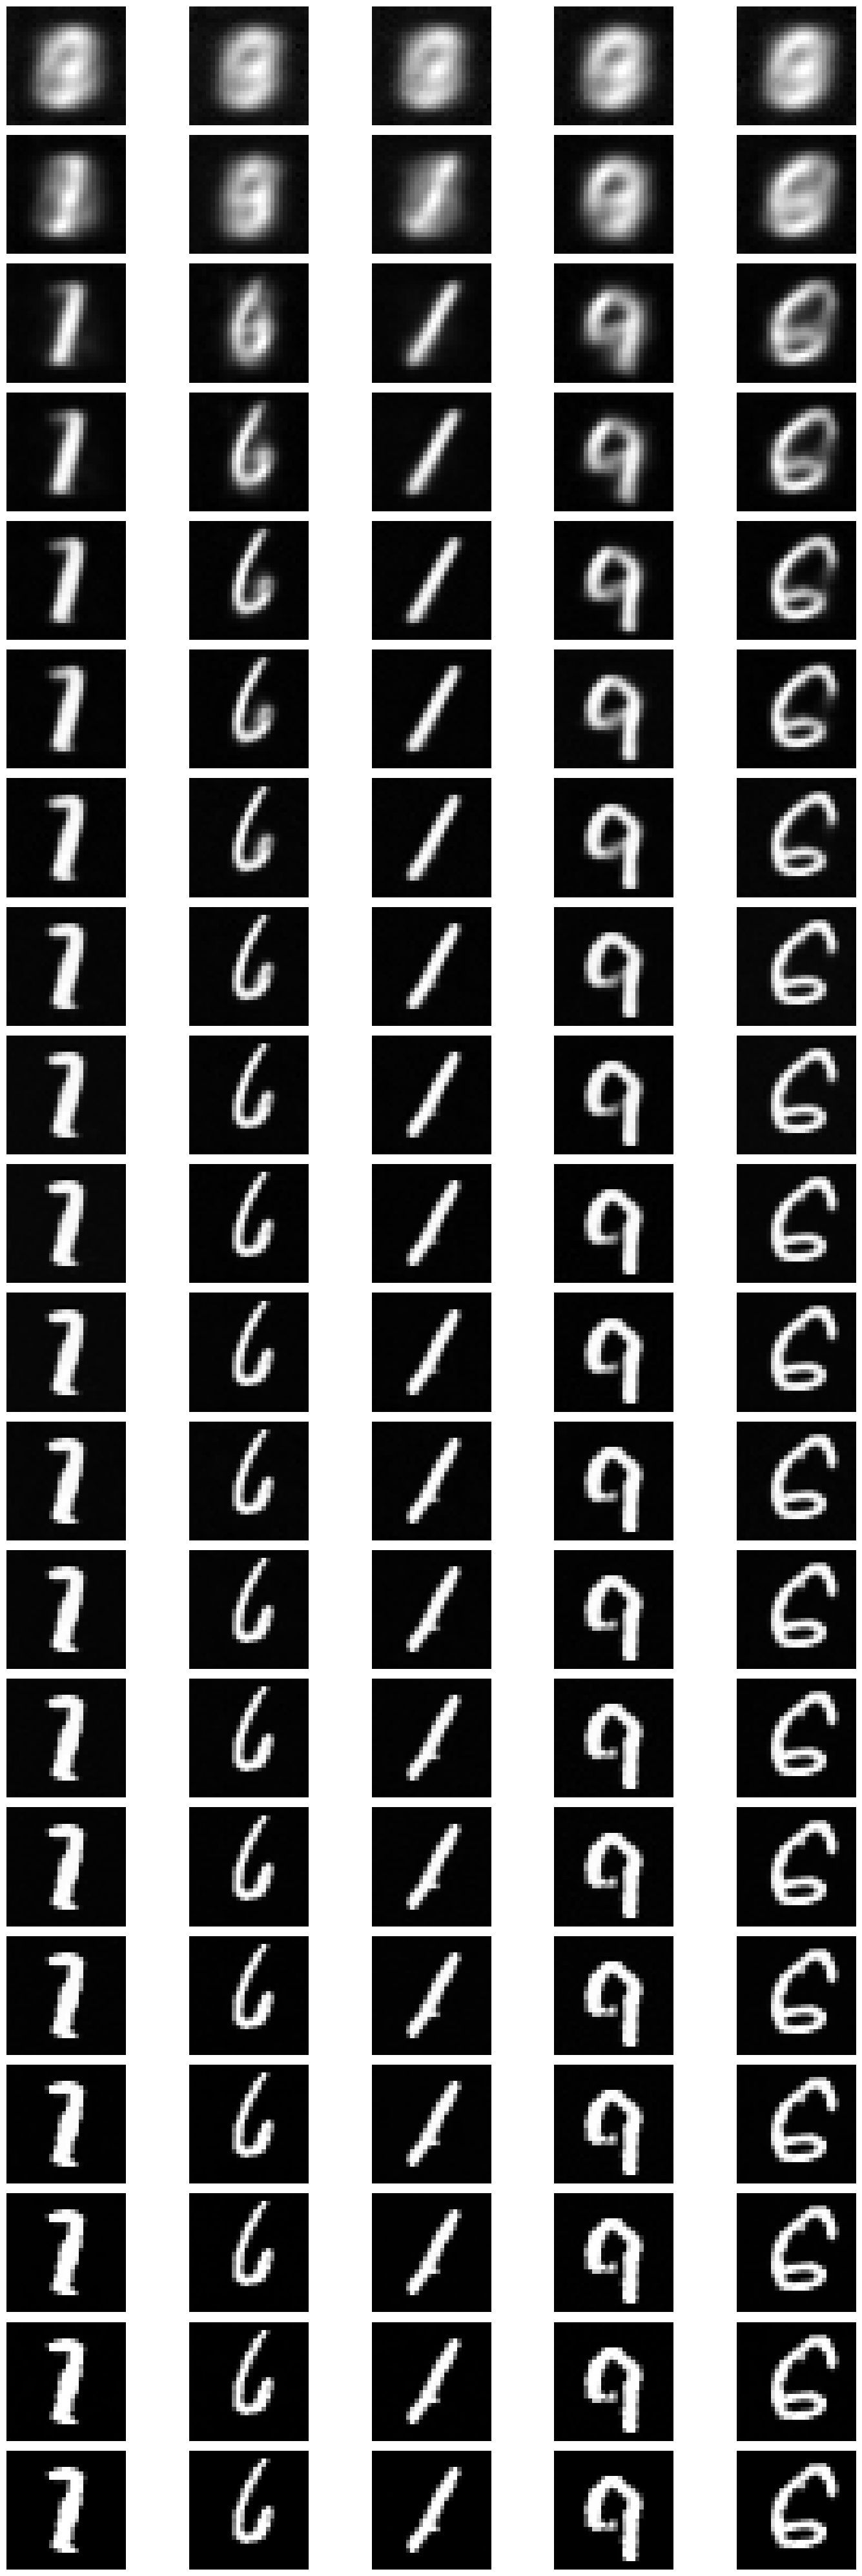

In [8]:
predictions = compute_predictions(trajectory, num_steps=num_steps)
visualize_image_trajectory(predictions, num_time_points=min(num_steps, 20))  # Show time points

Minimum MSE values: [0.21269138157367706, 0.1689668744802475, 0.041220035403966904, 0.2192065268754959, 0.40416672825813293]


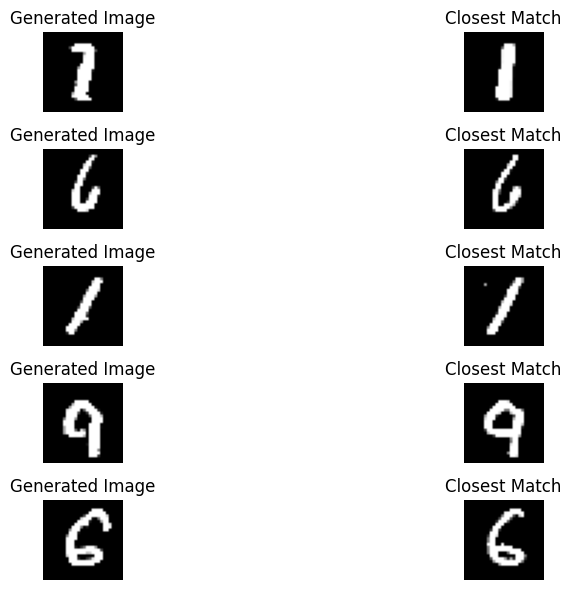

In [9]:
# Get final images from trajectory
generated_images = trajectory[-1]  # Your trajectory tensor

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
subset = torch.utils.data.Subset(mnist_train, range(60000))  # First 1000 samples
dataloader = torch.utils.data.DataLoader(subset, batch_size=len(subset))
images, labels = next(iter(dataloader))
images, labels = images.to(device), labels.to(device)

min_mses, closest_indices = find_closest_matches(
    generated_images, images, device = device)

# Display comparisons
display_comparisons(generated_images, images, 
                   closest_indices,
                   num_display=5)

# Fixed Noise Seed

In [10]:

# Load the saved data
saved_data = torch.load('saved_samples/noise_samples.pt')

# Extract components
seed = saved_data['seed']
noise_samples = saved_data['noise_samples']

# Verify reproducibility by regenerating with same seed
torch.manual_seed(seed)
regenerated = torch.randn(size=(5, 1, 28, 28))

# Check if they match
print("Do loaded and regenerated samples match?", torch.allclose(noise_samples, regenerated))

# Move back to original device if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_samples = noise_samples.to(device)

print(f"Loaded {len(noise_samples)} samples generated with seed {seed}")

Do loaded and regenerated samples match? False
Loaded 5 samples generated with seed 2


In [11]:
start_time = time.time()
num_steps = 50

# Generate trajectory with Euler method
trajectory = model_forward_euler_integration(
    model=model,
    initial_points=noise_samples,
    t_start=0.0,
    t_end=1.0,
    num_steps=num_steps,
    device='cuda'
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")

Integration completed in 1.0355 seconds


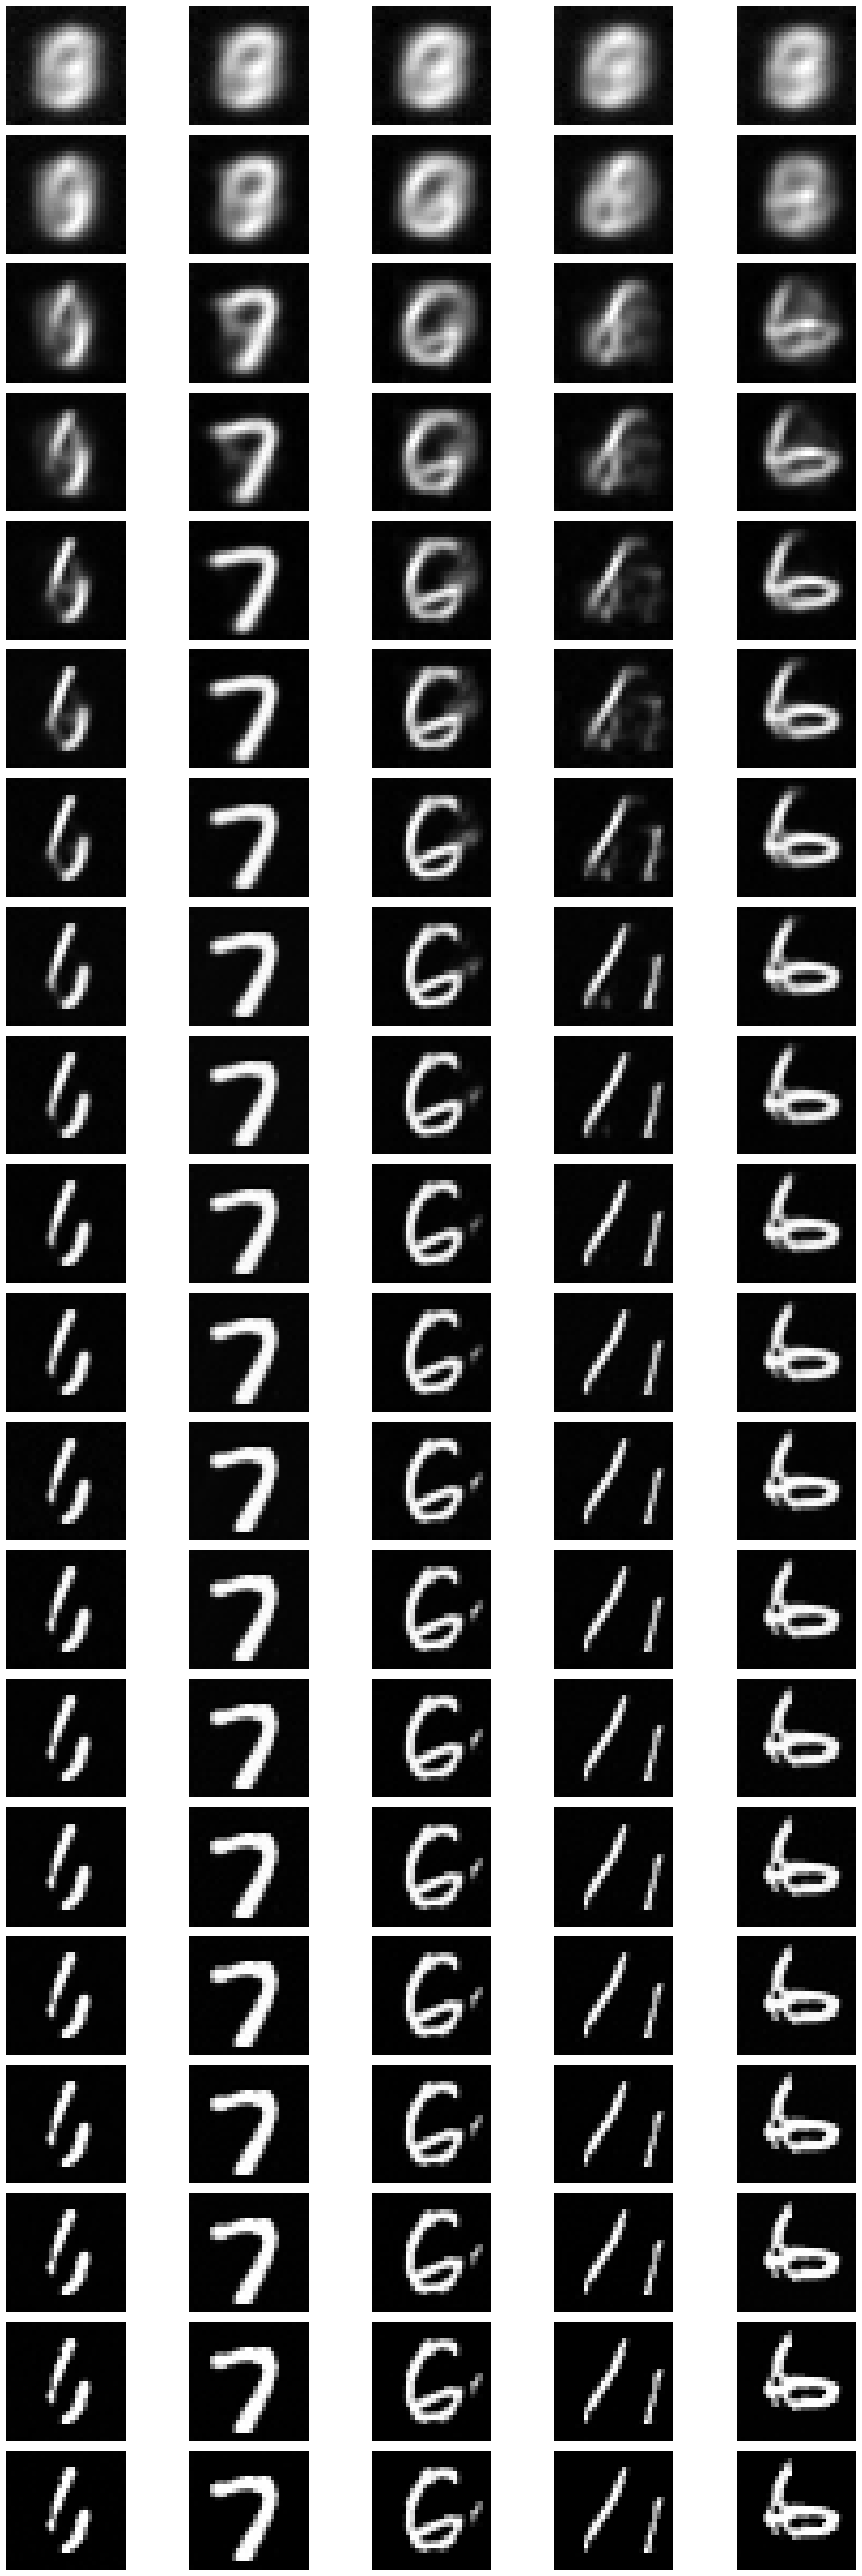

Minimum MSE values: [0.3064350485801697, 0.18963076174259186, 0.4552929103374481, 0.4558246433734894, 0.45845872163772583]
Figure saved as results/model.png


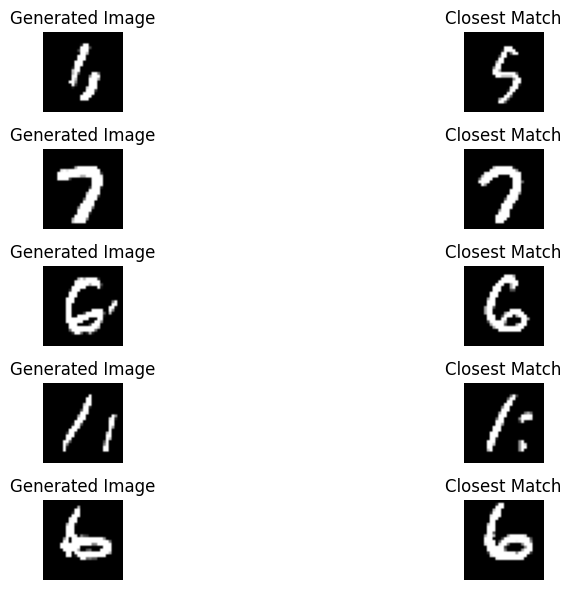

In [12]:
predictions = compute_predictions(trajectory, num_steps=num_steps)
visualize_image_trajectory(predictions, num_time_points=min(num_steps, 20))  # Show time points
generated_images = trajectory[-1]

min_mses, closest_indices = find_closest_matches(
    generated_images, images, device = device)

display_comparisons(generated_images, images, 
                       closest_indices,
                       num_display=5, figsize=(12, 6),
                       filename="results/model.png")